In [1]:
import torch
import torch.nn.functional as F
from torch.optim import Adam
from models.Bayes3FC import Bayesian3FC
from models.F3FC import F3FC
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device("cpu")
class Data:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return self.x.size(0)

In [4]:
data_file = "DATA/carbon_nanotubes.csv"
data = pd.read_csv(data_file, sep=";", decimal=",")
target_label = "Calculated atomic coordinates w"
inputs_labels = [col for col in data.columns if target_label not in col]
target_labels = [col for col in data.columns if target_label in col]
X = torch.tensor(data[inputs_labels].values).type(torch.double)
Y = torch.tensor(data[target_labels].values).type(torch.double)

In [16]:
inds = np.arange(X.size(0))
torch.manual_seed(12345)
np.random.seed(12345)
np.random.shuffle(inds)
test_size = 0.2
batch_size = 20
test_len = int(test_size * X.size(0))
train_inds, test_inds = inds[test_len:], inds[:test_len]

In [17]:
X_train, X_test = X[train_inds], X[test_inds]
Y_train, Y_test = Y[train_inds], Y[test_inds]

In [18]:
train_loader = torch.utils.data.DataLoader(Data(X_train, Y_train), batch_size=batch_size)
lr_start = 0.00001
fc_model = F3FC(7, 30, 20, 1).to(device)
optimizer = Adam(fc_model.parameters(), lr=lr_start)

In [19]:
def run_model(model, train_loader, device, num_epochs=30):
    num_epochs = num_epochs
    pbar = tqdm(range(num_epochs))
    for i in pbar:
        for bi, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            out = model(x)

            loss = F.mse_loss(out, y)
            loss.backward()
            optimizer.step()

        pbar.set_description(f"{loss}")

run_model(fc_model, train_loader, device)

0.005492341912896422: 100%|██████████| 30/30 [00:08<00:00,  3.56it/s] 


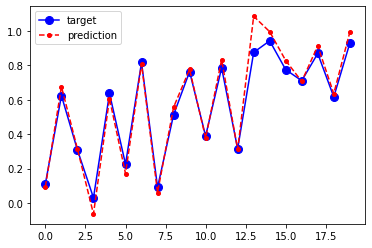

In [20]:
def plot_model_pred(model, Y_test, X_test):
    Y_sample = Y_test.detach().numpy()[:20]
    Y_pred_sample = model(X_test).detach().numpy()[:20]
    plt.plot(Y_sample, "bo-", ms=8, label="target")
    plt.plot(Y_pred_sample, "ro--", ms=4, label="prediction")
    plt.legend()
    plt.show()
plot_model_pred(fc_model, Y_test, X_test)

In [21]:
bayes_model = Bayesian3FC(7, 30, 20, 1).to(device)
run_model(bayes_model, train_loader, device)

5548.82569595628: 100%|██████████| 30/30 [00:14<00:00,  2.03it/s]  


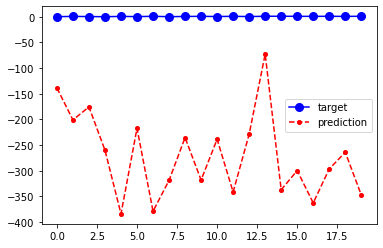

In [22]:
plot_model_pred(bayes_model, Y_test, X_test)